In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import missingno as msno
#from google.colab import data_table
from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler,MinMaxScaler,PowerTransformer,StandardScaler
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression

In [2]:
final_df = pd.read_csv('./final_data_imputed_20_01_2024.csv')
final_df

,Date,opening_price,highest_price,lowest_price,closing_price,transactions_in_blockchain,avg_block_size,sent_by_adress,avg_mining_difficulty,avg_hashrate,...,avg_transaction_value,median_transaction_value,tweets,google_trends,active_addresses,top100_to_total_percentage,avg_fee_to_reward,number_of_coins_in_circulation,miner_revenue,next_day_closing_price
0,2013-01-02,13.24,13.24,12.77,13.22,39280,114077,31809,2979637,2.280465e+13,...,650.617,14.514,8193.000000,1.497000,43104.0,19.597,0.835,1.062158e+07,5.486525e+04,13.09
1,2013-01-03,13.12,13.19,12.98,13.09,42147,108023,38197,2979637,2.372489e+13,...,542.730,19.732,8193.000000,1.798000,51268.0,19.621,0.925,1.062870e+07,4.811833e+04,13.19
2,2013-01-04,13.09,13.26,12.96,13.19,48436,141811,34990,2979637,2.260818e+13,...,632.431,11.384,8193.000000,1.841000,47341.0,19.540,1.000,1.063242e+07,5.087274e+04,13.19
3,2013-01-05,13.12,13.24,12.84,13.19,39455,118240,38008,2979637,2.259070e+13,...,697.556,13.945,8193.000000,1.826000,53417.0,19.543,0.885,1.063320e+07,5.139673e+04,13.15
4,2013-01-06,13.19,13.19,13.03,13.15,32881,100608,30021,2979637,2.076659e+13,...,436.105,17.618,8193.000000,2.187000,42211.0,19.604,0.957,1.064015e+07,5.696882e+04,13.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4027,2024-01-15,41700.91,43332.79,41682.62,42492.35,408385,754220,375303,73197634206448,4.427672e+20,...,73720.000,30.199,203764.795351,10.443000,658906.0,14.986,14.149,1.959027e+07,4.437143e+07,43131.47
4028,2024-01-16,42483.97,43569.31,42033.30,43131.47,469997,752060,403561,73197634206448,4.766308e+20,...,84100.000,0.234,203772.017712,9.137000,653810.0,14.980,13.728,1.959075e+07,4.454216e+07,42741.63
4029,2024-01-17,43132.80,43185.47,42164.99,42741.63,449294,747345,458901,73197634206448,4.007983e+20,...,115218.000,56.659,203778.129883,8.050000,689721.0,14.981,12.154,1.959123e+07,4.319201e+07,41292.17
4030,2024-01-18,42740.17,42879.39,40605.54,41292.17,483875,739462,474198,73197634206448,4.756212e+20,...,99128.000,87.060,203783.000000,8.920000,732999.0,14.975,12.027,1.959166e+07,4.034195e+07,41629.02


This function is useful for understanding the importance of different features in a dataset and selecting the most significant ones for further analysis. It leverages visualization techniques to make feature importance information more accessible.

In [3]:
def feature_imp(df,feat_importance,n_select_features):
    feat_imp_df = pd.DataFrame(data = {"Feature Name": df.columns,"Feature Importance":feat_importance})

    feat_imp_df = feat_imp_df.sort_values("Feature Importance",ascending=False)[:n_select_features]
    
    # Create a bar plot to visualize the feature importance's
    fig,ax = plt.subplots(figsize=(14,12))
    ax = sns.barplot(x = "Feature Importance",y = "Feature Name",
                    data=feat_imp_df,palette="nipy_spectral")
    plt.title('Feature Importances')

    cmap = plt.get_cmap('nipy_spectral_r',n_select_features)
    minfi = min(feat_imp_df['Feature Importance'])
    maxfi = max(feat_imp_df['Feature Importance'])
    norm = mpl.colors.Normalize(vmin=minfi,vmax=maxfi)
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
    sm.set_array([])
    
    # Show the color bar
    # plt.colorbar(sm,ticks=np.linspace(minfi,maxfi,n_select_features),
    #             boundaries=np.arange(minfi,maxfi+0.001,.0001))
    
    # Display the grid lines along the x-axis
    ax.xaxis.grid()
    # Show the plot
    plt.show()
    # Return the DataFrame with feature importance's and selected features from the original DataFrame
    return feat_imp_df,df[feat_imp_df['Feature Name']]

Data Scaling

In [4]:
X = final_df.drop(['Date','next_day_closing_price'],axis=1)

scaler = RobustScaler()
X_scaled = X.copy()
X_scaled[X.columns] = scaler.fit_transform(X[X.columns])

scaler = MinMaxScaler()
X_scaled[X.columns] =  scaler.fit_transform(X_scaled[X.columns])

X_scaled

,opening_price,highest_price,lowest_price,closing_price,transactions_in_blockchain,avg_block_size,sent_by_adress,avg_mining_difficulty,avg_hashrate,mining_profitability,...,avg_block_time,avg_transaction_value,median_transaction_value,tweets,google_trends,active_addresses,top100_to_total_percentage,avg_fee_to_reward,number_of_coins_in_circulation,miner_revenue
0,2.221601e-06,1.304773e-06,0.000000,1.925380e-06,0.012995,0.041224,0.002200,1.483928e-10,6.350186e-09,0.167238,...,0.200829,0.000164,0.002665,0.021337,0.000023,0.000774,0.000012,0.015024,0.000000,0.000144
1,4.443201e-07,5.798991e-07,0.000003,0.000000e+00,0.017085,0.034658,0.010059,1.483928e-10,7.849089e-09,0.170458,...,0.173717,0.000120,0.003629,0.021337,0.000512,0.007849,0.000012,0.017098,0.000794,0.000060
2,0.000000e+00,1.594722e-06,0.000003,1.481061e-06,0.026056,0.071304,0.006114,1.483928e-10,6.030176e-09,0.169185,...,0.200829,0.000157,0.002088,0.021337,0.000582,0.004446,0.000012,0.018826,0.001209,0.000094
3,4.443201e-07,1.304773e-06,0.000001,1.481061e-06,0.013245,0.045740,0.009827,1.483928e-10,6.001695e-09,0.155329,...,0.242354,0.000183,0.002560,0.021337,0.000557,0.009712,0.000012,0.016176,0.001296,0.000101
4,1.481067e-06,5.798991e-07,0.000004,8.886368e-07,0.003867,0.026616,0.000000,1.483928e-10,3.030550e-09,0.173229,...,0.227735,0.000077,0.003238,0.021337,0.001144,0.000000,0.000012,0.017835,0.002071,0.000170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4027,6.174245e-01,6.280255e-01,0.628370,6.291439e-01,0.539517,0.735504,0.424816,1.000000e+00,7.211892e-01,0.000002,...,0.367755,0.029986,0.005561,0.559923,0.014560,0.534464,0.000004,0.321819,0.999761,0.553210
4028,6.290222e-01,6.314544e-01,0.633658,6.386096e-01,0.627406,0.733161,0.459583,1.000000e+00,7.763468e-01,0.000002,...,0.310109,0.034222,0.000029,0.559943,0.012438,0.530047,0.000003,0.312118,0.999814,0.555341
4029,6.386318e-01,6.258897e-01,0.635644,6.328359e-01,0.597873,0.728048,0.527670,1.000000e+00,6.528292e-01,0.000003,...,0.329860,0.046922,0.010446,0.559960,0.010671,0.561170,0.000003,0.275849,0.999868,0.538491
4030,6.328167e-01,6.214523e-01,0.612128,6.113685e-01,0.647202,0.719498,0.546490,1.000000e+00,7.747025e-01,0.000003,...,0.238621,0.040355,0.016058,0.559973,0.012085,0.598677,0.000003,0.272922,0.999916,0.502922


In [5]:
y = final_df['next_day_closing_price']
rf = RandomForestRegressor(n_estimators=100,n_jobs=-1,bootstrap=True,
                           verbose=5,random_state=1)
rf.fit(X_scaled,y)
     

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100building tree 32 of 100

building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.5s


building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done  98 out of 100 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished


RandomForestRegressor(n_jobs=-1, random_state=1, verbose=5)

In [6]:
feat_range = list(range(10,60,5))

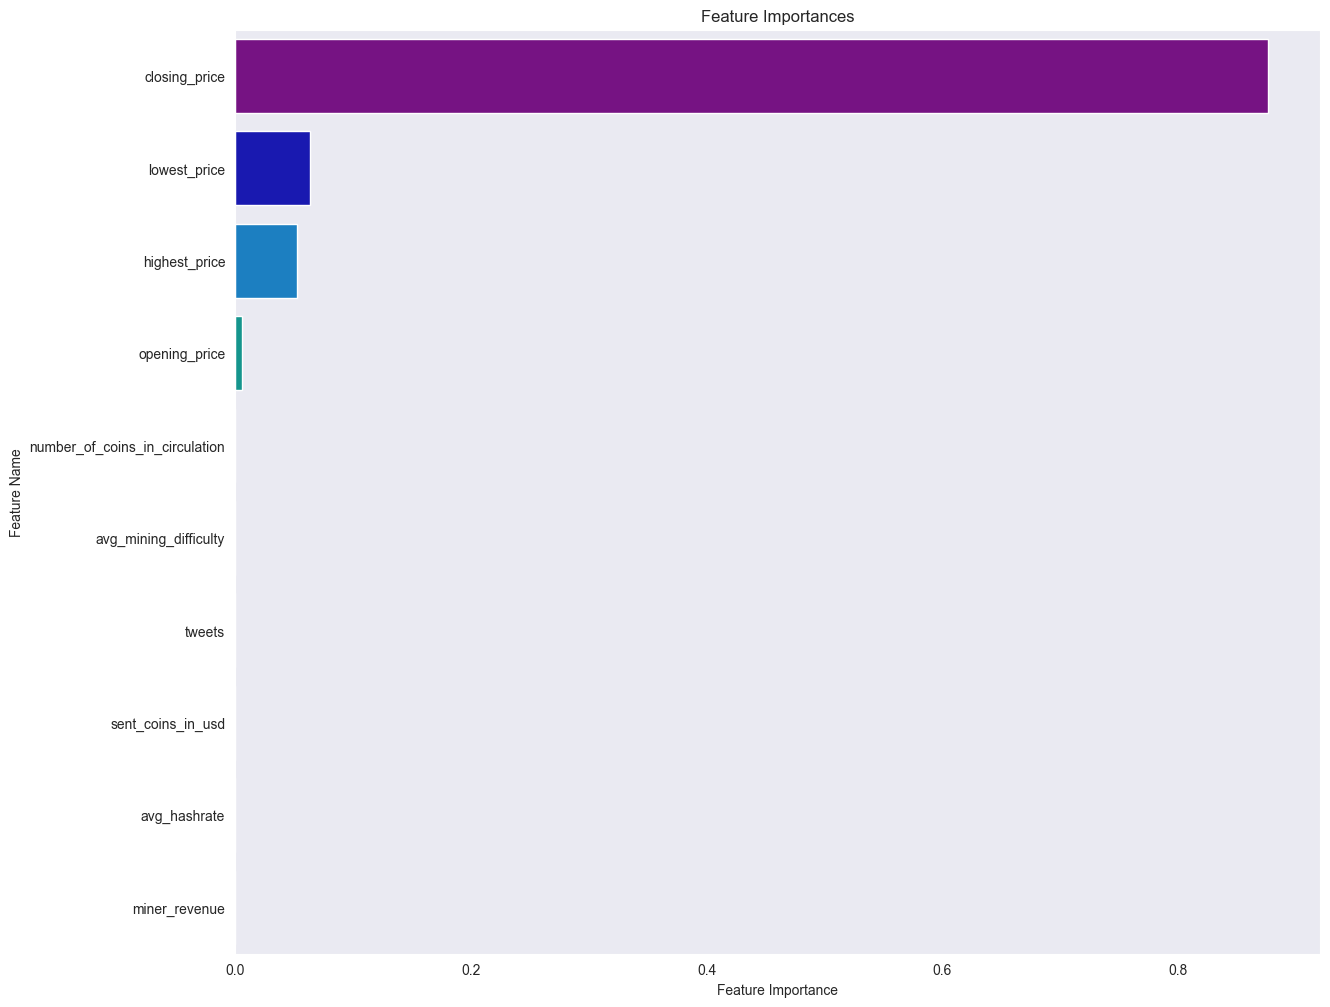

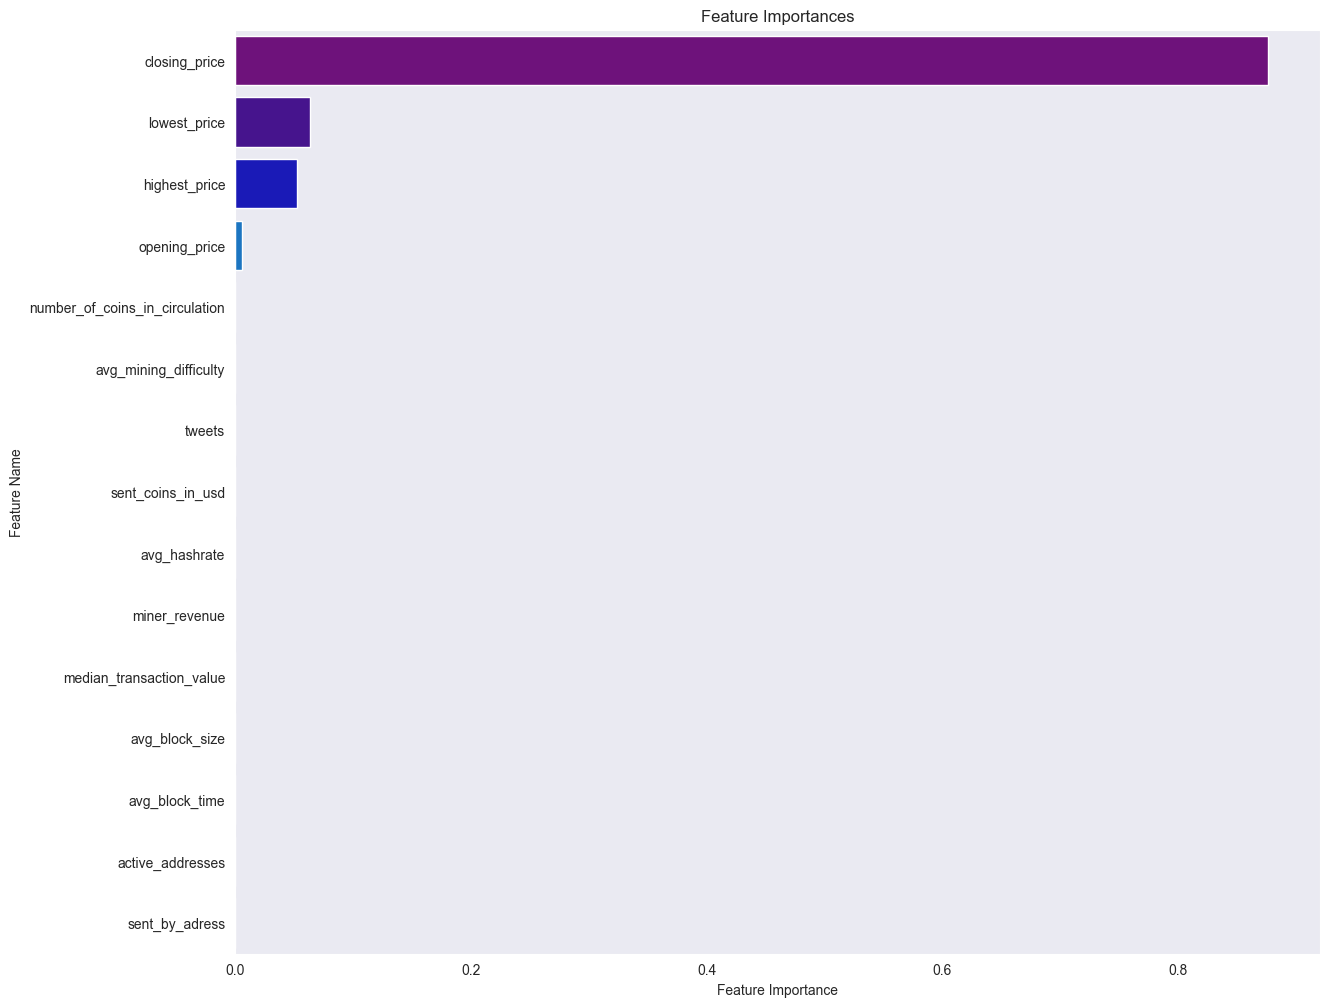

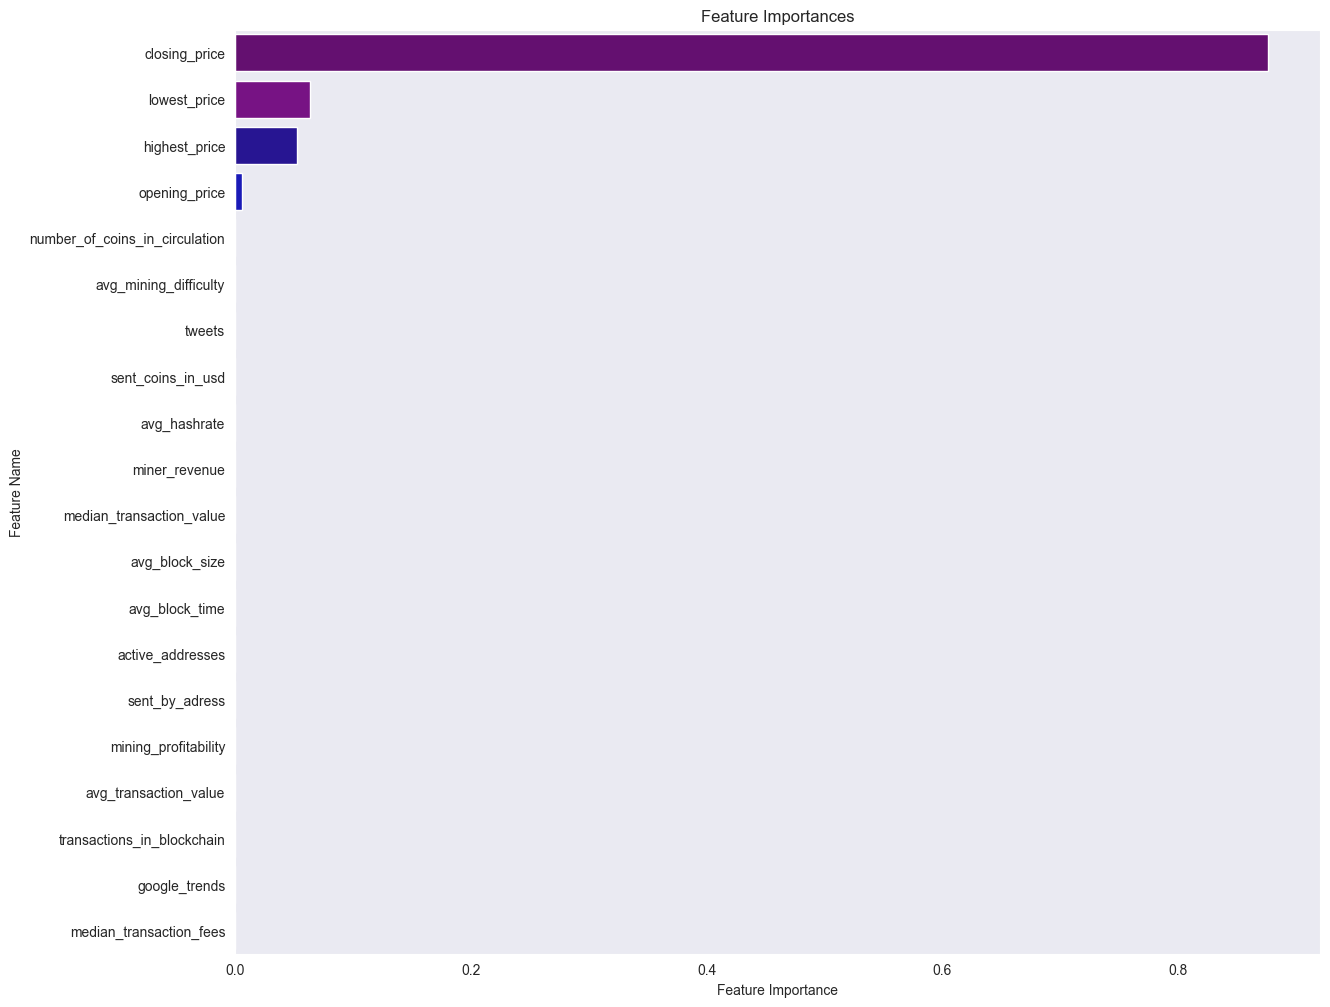

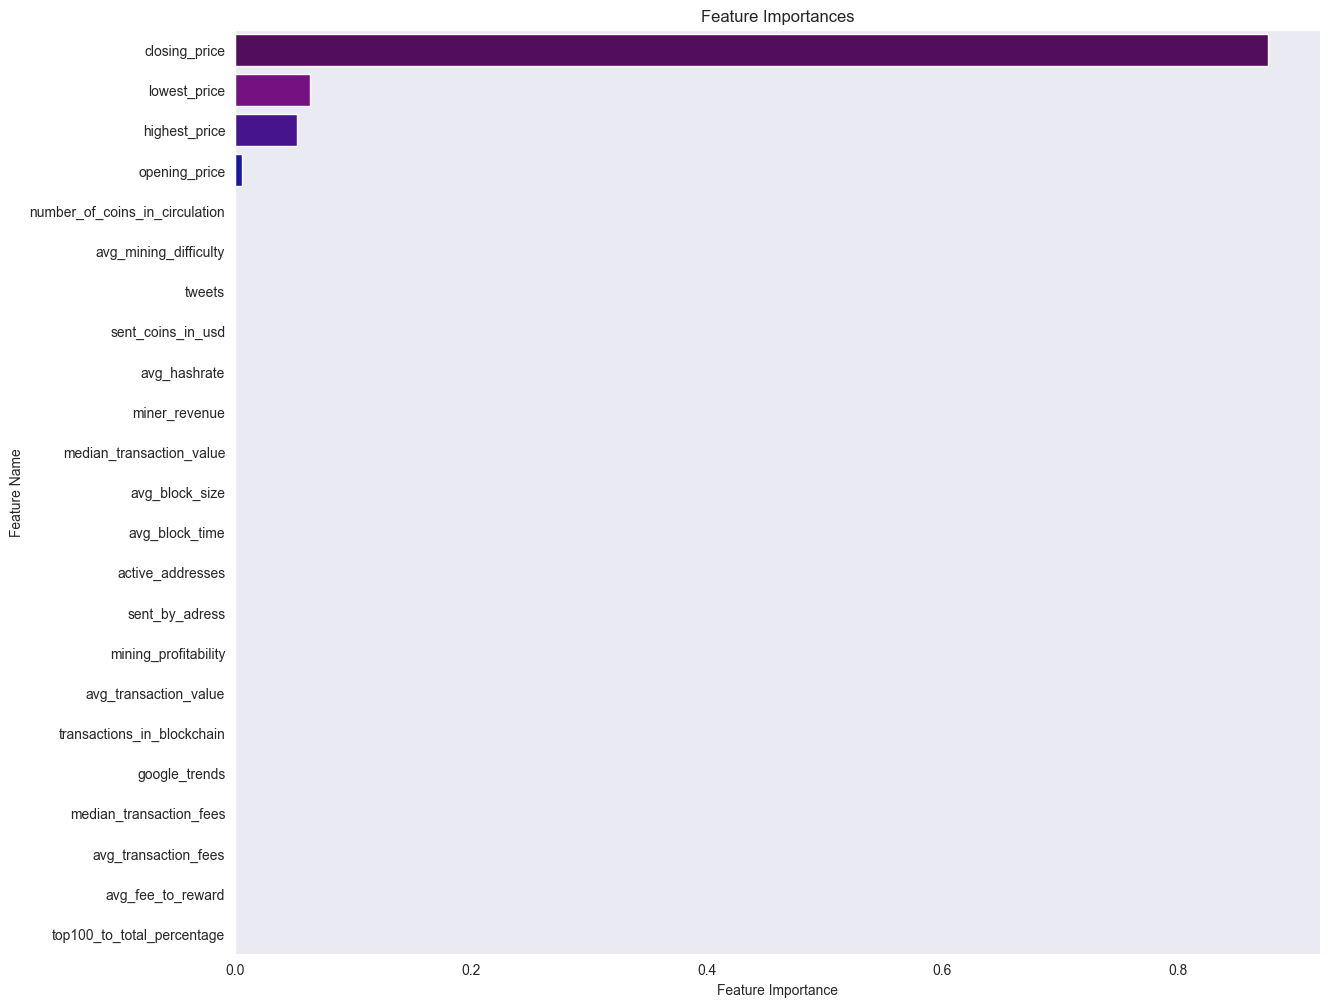

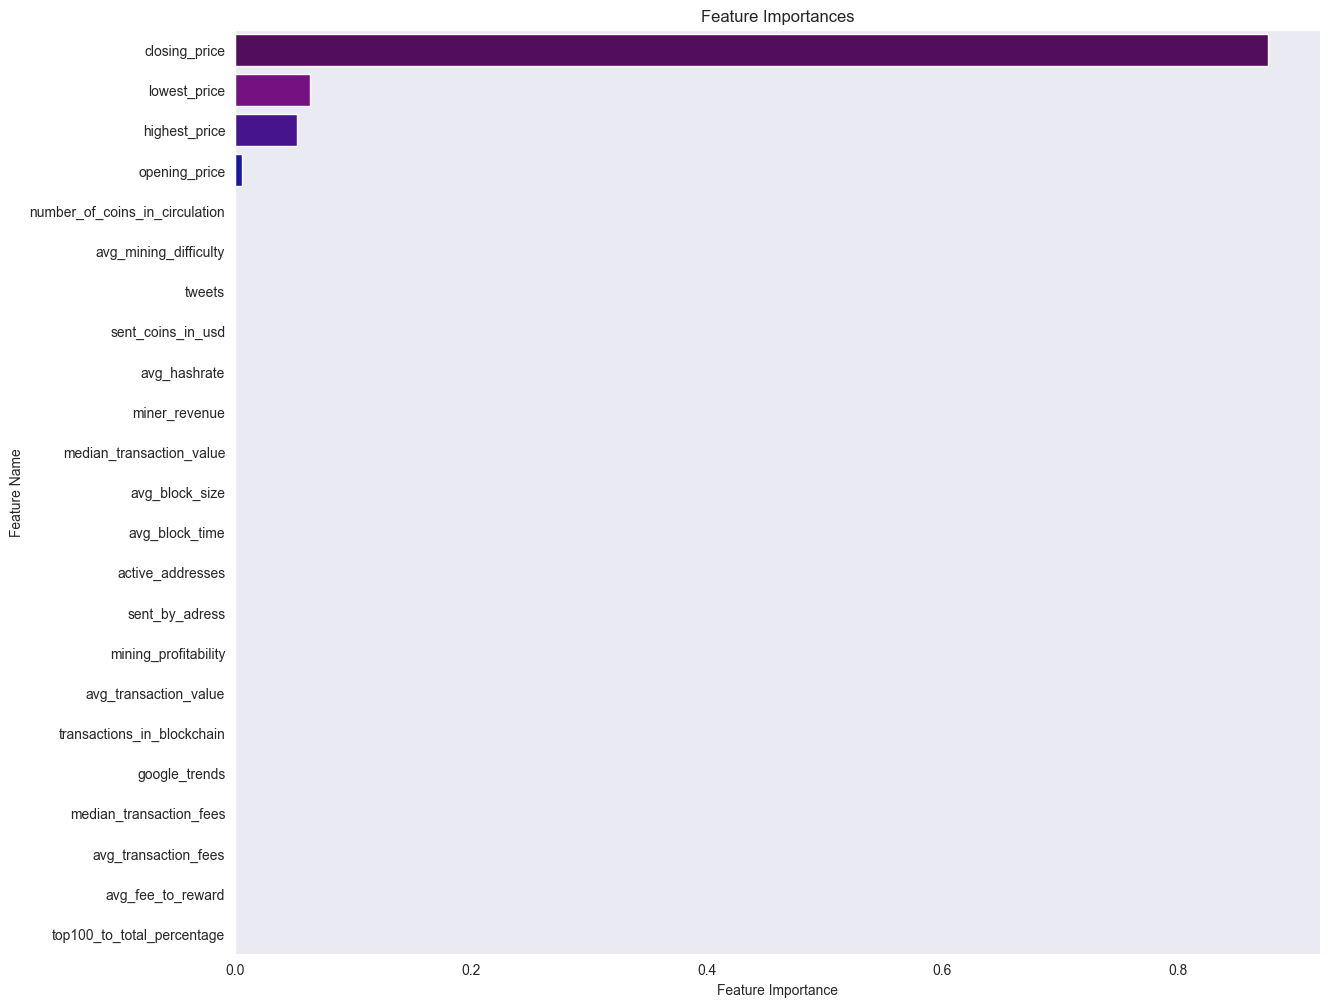

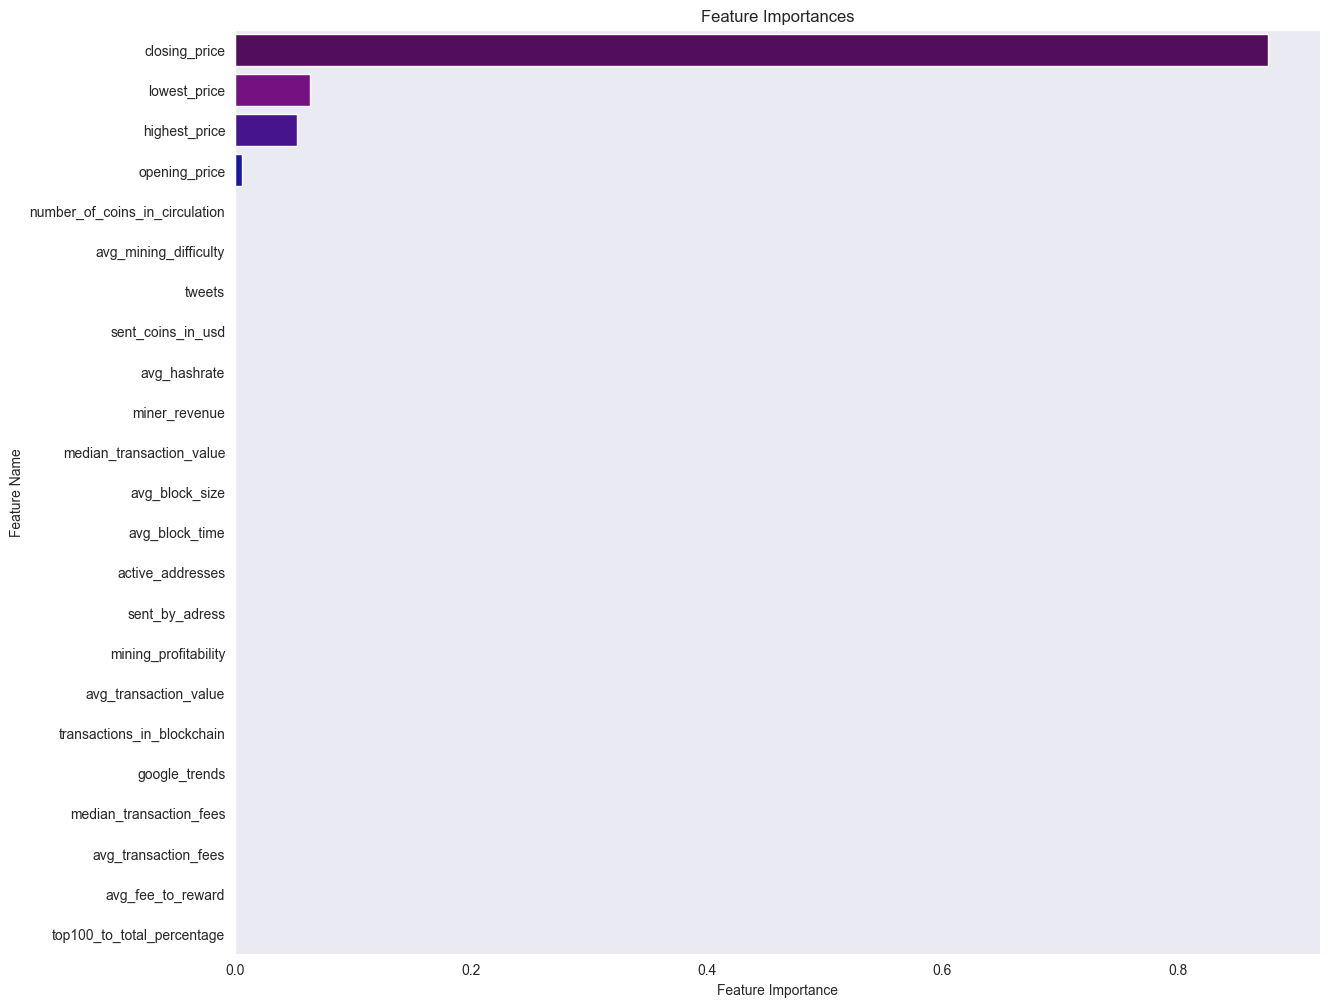

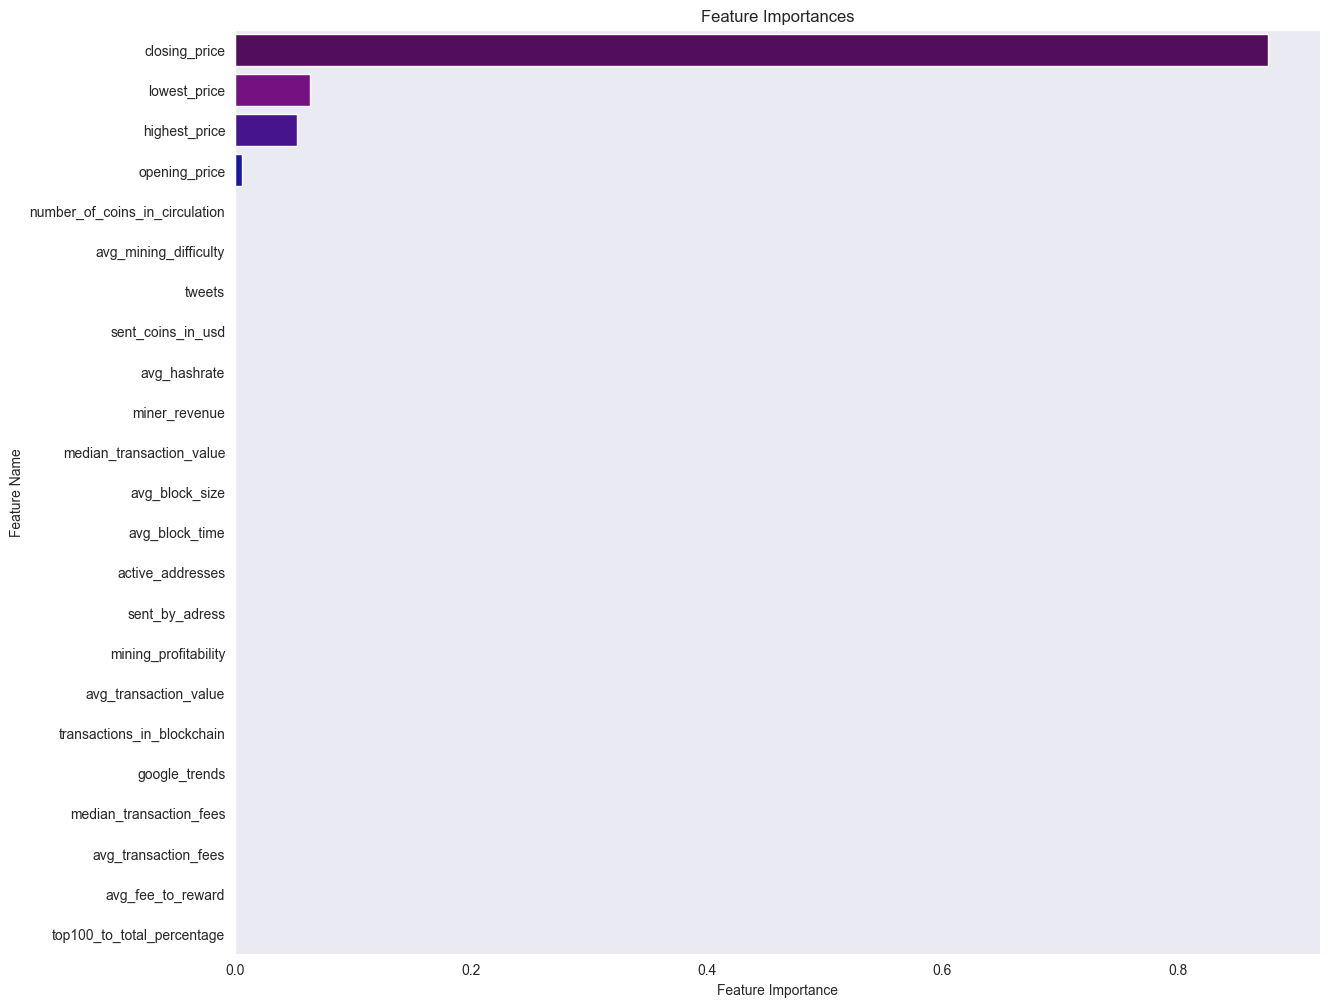

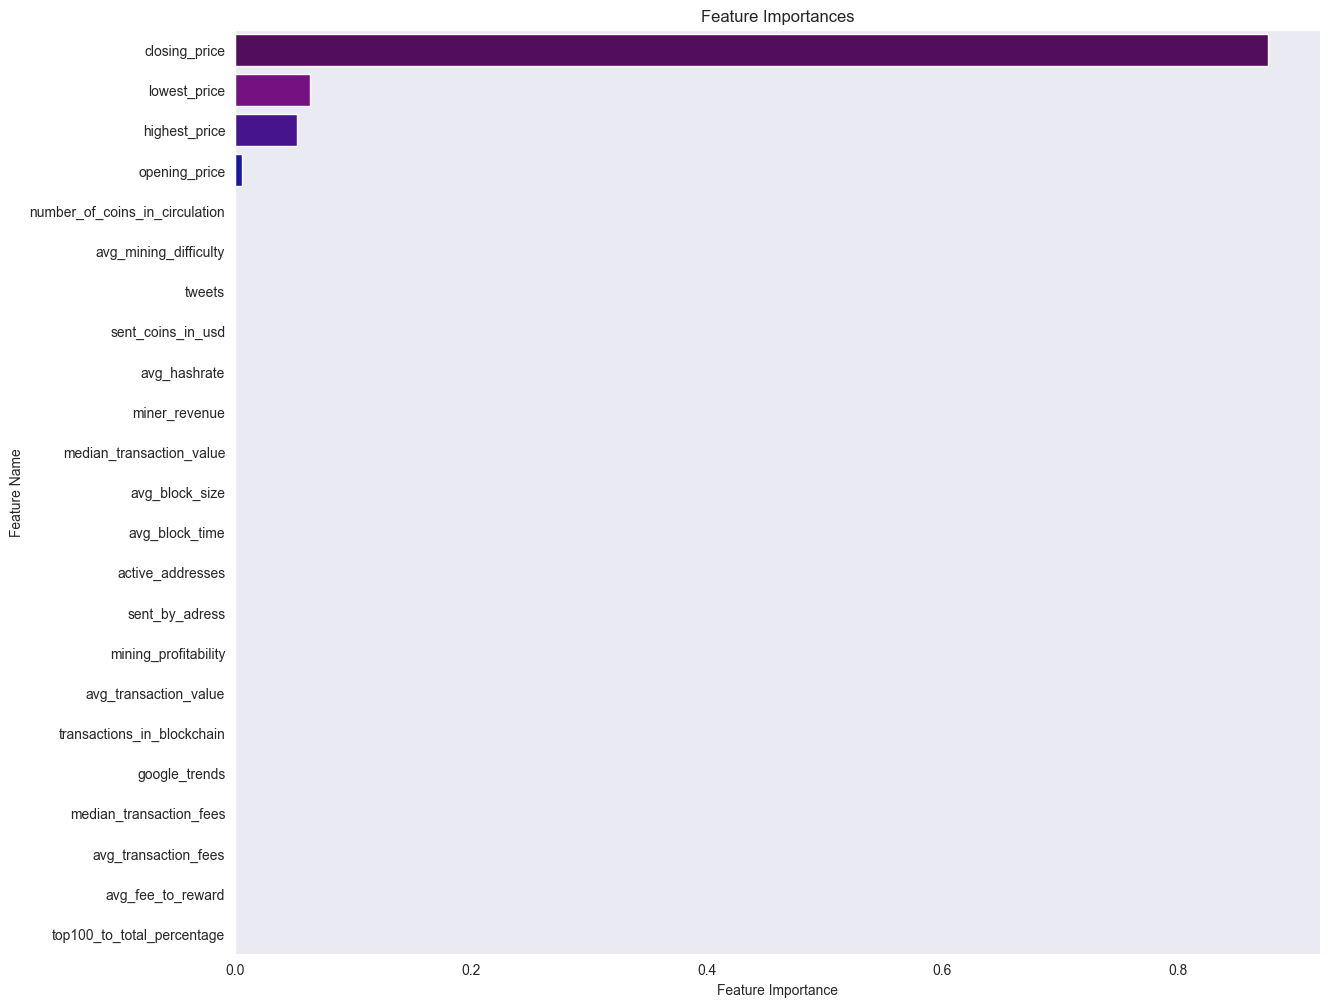

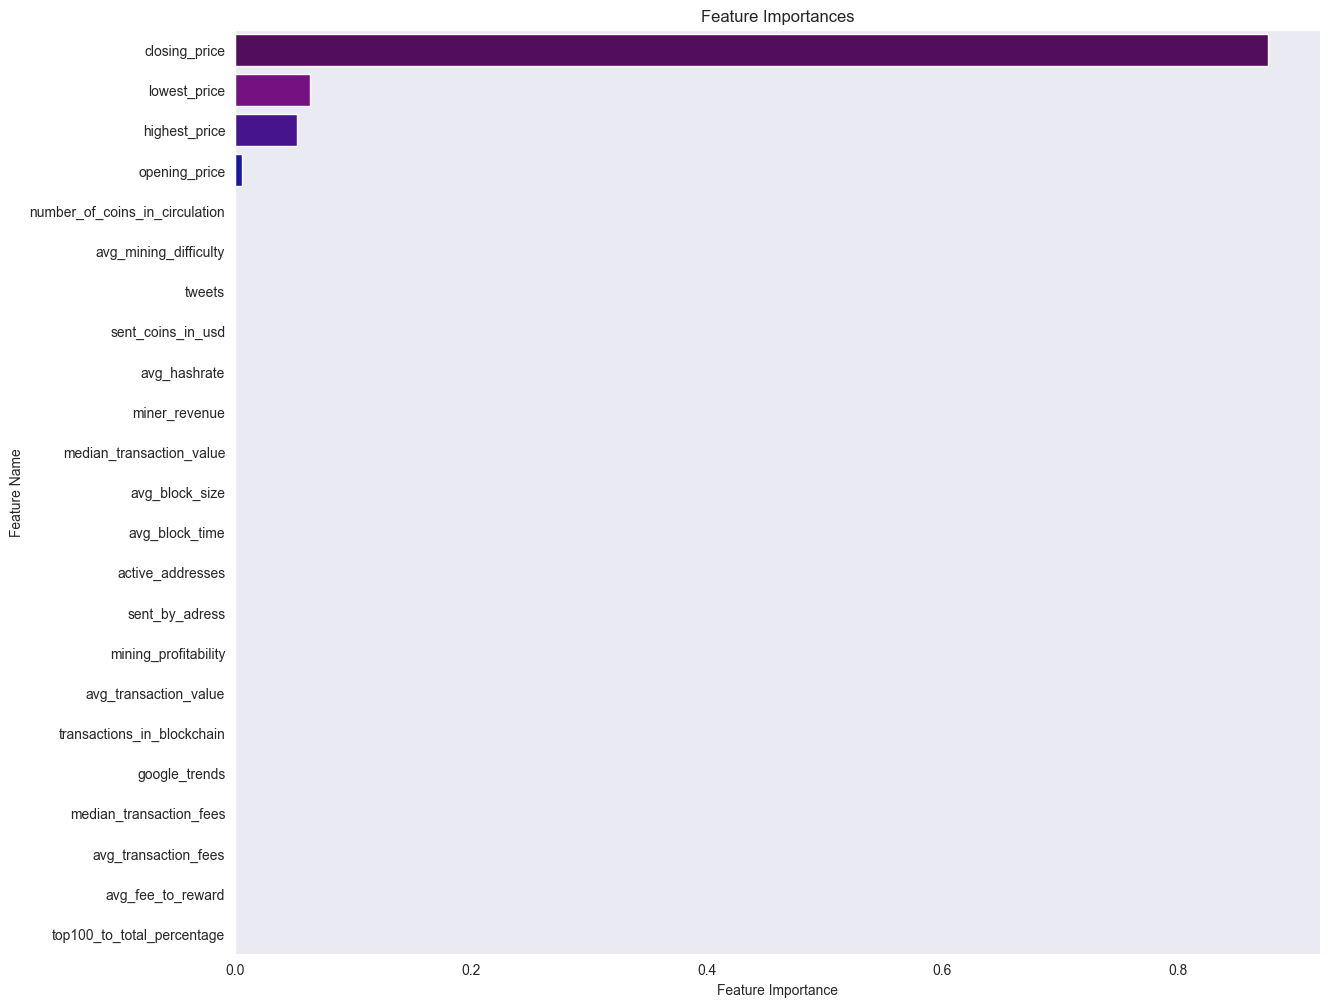

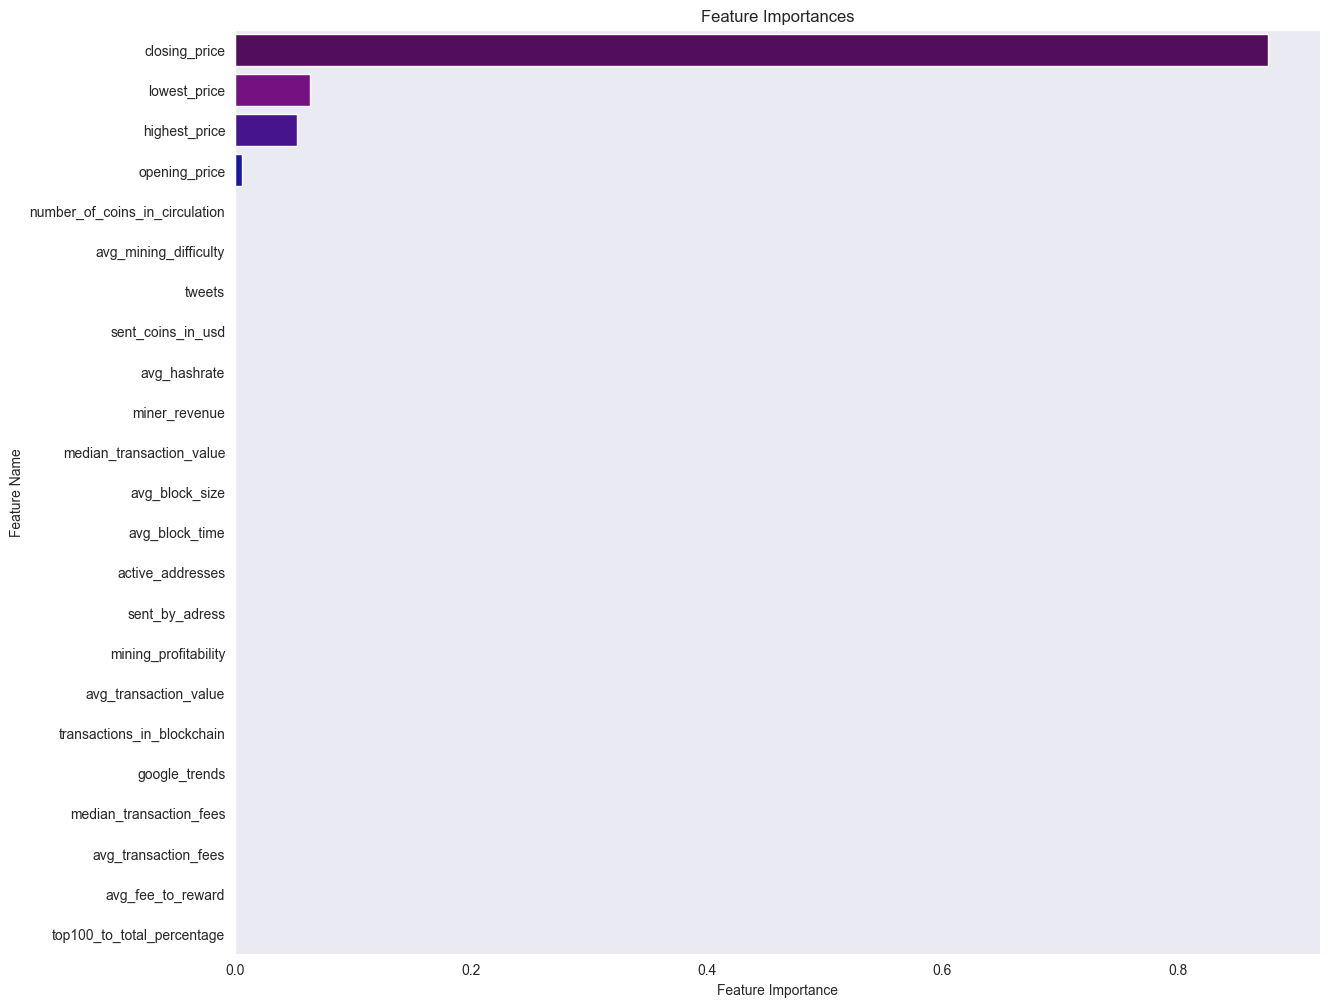

In [8]:
for i in feat_range:
    feat_imp_df,final_df_next_day = feature_imp(X_scaled,rf.feature_importances_,i)
    final_df_next_day.insert(loc=0, column='Date', value=final_df['Date'])
    final_df_next_day['next_day_closing_price'] = final_df['next_day_closing_price']
    feat_imp_df.to_csv(f'./feature_imp_{i}.csv',index=False)
    final_df_next_day.to_csv(f'./final_df_next_day_{i}.csv',index=False)
     